In [1830]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import regex as re
from copy import deepcopy 
import random
import datetime as dt
import requests
import os
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager

## Scraping

In [1831]:
# url filters: jobs posted within past day, within 15 miles of New York, NY
google_jobs_url = 'https://www.google.com/search?q=jobs&oq=google+jobs+data+analyst&aqs=chrome..69i57j69i59j0i512j0i22i30i625l4j69i60.4543j0j7&sourceid=chrome&ie=UTF-8&ibp=htl;jobs&sa=X&ved=2ahUKEwjXsv-_iZP9AhVPRmwGHX5xDEsQutcGKAF6BAgPEAU&sxsrf=AJOqlzWGHNISzgpAUCZBmQA1mWXXt3I7gA:1676311105893#fpstate=tldetail&htivrt=jobs&htichips=city:Owg_06VPwoli_nfhBo8LyA%3D%3D,date_posted:today&htischips=city;Owg_06VPwoli_nfhBo8LyA%3D%3D:New%20York_comma_%20NY,date_posted;today&htilrad=24.1401&htidocid=9dwQD_uVzp1Nu-9BAAAAAA%3D%3D'
# path to CSV where google jobs dataset will be held
descr_df_path = '/Users/ravram/Desktop/pay-transparency/data/output/google-jobs-cronjob.csv' # need to change path when put on server
# path to CSV where extra column data will be held
scroll_df_path = '/Users/ravram/Desktop/pay-transparency/data/output/google-jobs-extra-cols-cronjob.csv' # need to change path when put on server

In [1921]:
# randomizing user agent from list found at https://github.com/udger/test-data/blob/master/CSV_data_example/userAgent_client_hints.csv
# trying to prevent banning/ limiting

ua_file = pd.read_csv('/Users/ravram/Desktop/pay-transparency/data/input/userAgent_client_hints.csv').rename(columns={'1':'User Agent'})

def get_random_ua(ua_df):
    
    random_num = random.choice(list(range(0,12)))
    user_agent = ua_df['User Agent'].loc[random_num]
    
    return user_agent

In [1934]:
# function that scrapes data from Google Jobs

def scrape_google_jobs(url, scroll_path_location, descr_path_location, postings):
    
# url: web url to the google jobs page that will be scraped (str)
# scroll_path_location: path to the CSV file where the data scraped from the scroll section of Google Jobs will be stored (str)
# descr_path_location: path to the CSV file where the data scraped from the job description section of Google Jobs will be stored (str)
# postings: number of job postings to be scraped -> can be increased by increments of 10 starting at 20, going up to limit of 150 (int)
    
    options = Options() # preparing to run in headless browser
    options.add_argument('headless') 

    # using sing selenium to launch and scroll through the Google Jobs page
    url = url
    driver = webdriver.Chrome(options=options)
    
    user_agent = get_random_ua(ua_file) #driver.execute_script("return navigator.userAgent;")
    user_agent = user_agent.replace("HeadlessChrome","Chrome")
    driver.execute_cdp_cmd('Network.setUserAgentOverride',{"userAgent": f'{user_agent}'})
    
    driver.get(url)
    
    # column names and paths to desired data on scroll section of website
    xpaths_scr = {
         'Role'            :"./div[2]",
         'Company'         :"./div[4]/div/div[1]",
         'Source'          :"./div[4]/div/div[3]",
         'Full / Part Time':".//*[name()='path'][contains(@d,'M20 6')]/ancestor::div[1]",
        }
    
    scrolls_to_do = postings # setting number of job postings to be scraped
    scrolls_done = 0
    data_scr = {key:[] for key in xpaths_scr} # data will be added to this dict
    
    # stay in while loop until desired number of postings have been scrolled to
    while scrolls_done < scrolls_to_do: 
        lis_scr = driver.find_elements(By.XPATH, "//li[@data-ved]//div[@role='treeitem']/div/div") # path to section of page where user can scroll through job postings 

        if (len(lis_scr) == scrolls_done) and (scrolls_to_do - scrolls_done) > 0: # in case the postings variable exceeds number of available job posting entries (otherwise code will be stuck in infinite loop)
        
            # print('\nNote: requested # of postings greater than available postings')
            scrolls_to_do = len(lis_scr) # resetting scrolls_to_do to the max length of lis_scr so can break out of while loop
            
        # scrolling down the page to make desired number of job postings load, therefore making them accessible for scraping
        for li_scr in lis_scr[scrolls_done:]:
            driver.execute_script('arguments[0].scrollIntoView({block: "center", behavior: "smooth"});', li_scr) 

            for key in xpaths_scr:
                try: # pull data at each path in the xpaths dict for each job posting
                    t = li_scr.find_element(By.XPATH, xpaths_scr[key]).get_attribute('innerText')
                except NoSuchElementException: # if can't find, indicate with text
                    t = '*missing data*'
                    
                data_scr[key].append(t) # add to data dict
            
            scrolls_done += 1
            print(f'{scrolls_done=}', end='\r') # to visualize how many scrolls have been performed
            time.sleep(.2)    
            
    scr_scraped_df = pd.DataFrame(data_scr) # convert to df
    
    print('')
    
    ####
    
    # column names and paths to desired data in job description page section of website
    xpaths_descr = { 
         'Role'               :"./div/div[1]/div/div[1]/h2",
         'Company'            :"./div/div[1]/div/div[2]/div[2]/div[1]",
         'Location'           :"./div/div[1]/div/div[2]/div[2]/div[2]",
         'Posted'             :"./div/div[3]/div[1]/span[2]/span",
         'All Sources Listed' :".//div[@class='B8oxKe BQC79e xXyUwe']",
         'Scraped Salary'     :".//span[@class='LL4CDc' and contains(@aria-label,'Salary')]/span",
         'Job Highlights'     :"./div/div[4]/div[1]/div[2]/g-expandable-container/div/g-expandable-content[2]/span",
         'Job Description'    :"./div/div[5]/div/span",
         'Any Other Text'     :"./div/div[4]" 
        }
    
    descr_done = 0
    data_descr = {key:[] for key in xpaths_descr} # data will be added to this dict
    data_descr['Date Scraped'] = []
    
    lis_descr = driver.find_elements(By.XPATH, "//*[@id='gws-plugins-horizon-jobs__job_details_page']") # path to description page for each job 
    
    for li_descr in lis_descr[0:scrolls_to_do]: # looping through desired number of job description pages
    
        for key in xpaths_descr:

            try: # pull data at each path in the xpaths dict for each job posting
                t = li_descr.find_element(By.XPATH, xpaths_descr[key]).get_attribute('innerText')
            except NoSuchElementException: # if can't find, indicate with text
                t = '*missing data*'
            if t == '': # in cases where element exists but is just ''
                t='*missing data*'
                
            data_descr[key].append(t) # add to data dict
            
        data_descr['Date Scraped'].append(dt.datetime.now()) # adding date scraped
            
        descr_done += 1
        print(f'{descr_done=}', end='\r') # to visualize how many description pages have been scraped
        time.sleep(.2)
        
    descr_scraped_df = pd.DataFrame(data_descr) # convert to df
    
    for ind in descr_scraped_df.index: # Any Other Text collects full text for posting... only worth keeping if Job Highlights and Description are both empty, otherwise redundant info just taking up space
        
        if (descr_scraped_df['Job Highlights'][ind] != '*missing data*') or (descr_scraped_df['Job Description'][ind] != '*missing data*'):
            
            descr_scraped_df.loc[ind, 'Any Other Text'] = np.nan # erasing this text if either Job Highlights or Job Description is present
    
    scr_path = scroll_path_location 
    
    if os.path.exists(scr_path): # if CSV already exists at the specified path, add the new data found in scr_scraped_df
        scr_original_df = pd.read_csv(scr_path) # convert existing CSV to df
        scr_original_df = pd.concat([scr_original_df,scr_scraped_df]) # add new data
        scr_original_df = scr_original_df.drop_duplicates() # drop entries with identical data 
        scr_original_df.to_csv(scr_path, index = False) # redownloading updated df to the specified path
    else: # otherwise, create new file at this path (for first time function is run)
        scr_scraped_df.to_csv(scr_path, index = False) 
        
    descr_path = descr_path_location 
    
    if os.path.exists(descr_path): # if CSV already exists at the specified path, add the new data found in descr_scraped_df 
        descr_original_df = pd.read_csv(descr_path) # convert existing CSV to df
        descr_original_df = pd.concat([descr_original_df,descr_scraped_df]) # add new data
        # drop entries with identical data in these columns... leaving Posted and All Sources Listed out of this in case duplicates are posted at dif times/ from dif sites
        descr_original_df = descr_original_df.drop_duplicates(subset=['Role','Company','Location','Scraped Salary','Job Highlights','Job Description', 'Any Other Text']) 
        descr_original_df.to_csv(descr_path, index = False) # redownloading updated df to the specified path
    else: # otherwise, create new file at this path (for first time function is run)
        descr_scraped_df.to_csv(descr_path, index = False)  
    
    return 

In [1935]:
scrape_google_jobs(google_jobs_url, scroll_df_path, descr_df_path, 30)

scrolls_done=30


'Mozilla/5.0 (Macintosh; Intel Mac OS X 11_1_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.192 Safari/537.36'

## Data Cleaning

In [1474]:
# function that cleans values in 'Source' and 'All Sources Listed' columns
# called by add_columns()

def clean_sources(df):
    
# df: df containing all of the compiled google jobs data (DataFrame)
    
    # replacing non-Source text with '*' (not likely any source names will contain this character)
    df['All Sources Listed'] = df['All Sources Listed'].fillna('')
    df['All Sources Listed'] = df['All Sources Listed'].str.replace('Apply on ','*') 
    df['All Sources Listed'] = df['All Sources Listed'].str.replace('Apply directly on ','*')
    
    #splitting on '*' to separate each source in a list
    df['All Sources Listed'] = df['All Sources Listed'].str.split('*')
    
    for ind in df.index: # removing any remaining spaces

        if '' in df['All Sources Listed'][ind]: df['All Sources Listed'][ind].remove('')
        if df['All Sources Listed'][ind] == []: df['All Sources Listed'][ind] = np.nan # replacing empty lists with NaN
            
    df['Source'] = df['Source'].str.replace('via ','') # removing 'via' from Source column values to isolate source name
    
    return df

In [1475]:
# function that adds columns from google_jobs_scr_df to google_jobs_descr_df based on unique job keys
# to be run after final dataset is compiled

def add_columns(google_jobs_descr_df, google_jobs_scr_df):
    
# google_jobs_descr_df: df containing all of the data from the job description page scrape (DataFrame)
# google_jobs_scr_df: df containing the columns from the Google Jobs scroll section to be added to google_jobs_descr_df (DataFrame)

    # initializing empty dicts
    source_dict = {}
    time_dict = {}
    
    for ind in google_jobs_scr_df.index: 
    
        col_key = google_jobs_scr_df['Role'][ind] + google_jobs_scr_df['Company'][ind] # create unique job key (title and company combined)
        
        source_dict[col_key] = google_jobs_scr_df['Source'][ind] # add Source data as value associated with job key
        time_dict[col_key] = google_jobs_scr_df['Full / Part Time'][ind] # add Full / Part Time data as value as value associated with job key
    
    # initializing columns in google_jobs_descr_df
    google_jobs_descr_df['Key'] = ''
    google_jobs_descr_df.insert(4, 'Source', '')
    google_jobs_descr_df.insert(5, 'Full / Part Time', '')
    
    for ind in google_jobs_descr_df.index:
        
        df_key = google_jobs_descr_df['Role'][ind] + google_jobs_descr_df['Company'][ind] # create unique job key to be matched with key in source_dict/time_dict
        google_jobs_descr_df['Key'][ind] = df_key
        
    for ind in google_jobs_descr_df.index:
    
        for col_key in source_dict.keys(): # matching keys between df and dicts

            if google_jobs_descr_df['Key'][ind] == col_key: 

                # adding values associated with key
                google_jobs_descr_df['Source'][ind] = source_dict[col_key] 
                google_jobs_descr_df['Full / Part Time'][ind] = time_dict[col_key]
            
    google_jobs_df = google_jobs_descr_df.drop(columns=['Key'])
    
    google_jobs_df = clean_sources(google_jobs_df) # cleaning up the entries in 'Source' and 'All Sources Listed'
    
    col = google_jobs_df.pop('All Sources Listed') # moving All Sources Listed next to Source column
    google_jobs_df.insert(5, col.name, col)
    
    return google_jobs_df # updated df with new columns added

In [1616]:
# function that cleans salary lists that would otherwise be labeled as ambiguous due to having over two entries
# specifically, removes duplicates from lists so that they won't be flagged as having over 2 entries
# called in pull_and_process_salaries()

def clean_salary_ambiguous(row):
    
# row: value in the 'Salary From Text' column at a given index of the df -> will be fed in as df['Salary From Text'][ind] (str)
    
    #k_list = [i for i in list(range(len(lst))) if 'k' in lst[i].lower()]
    
    # since letters are about to be removed below, need to note when a number is really meant to be multiplied by 1000
    if 'k' in ''.join(row).lower():
        magnitude = 'k'
    else:
        magnitude = ''
        
    ambig_lst = []
        
    for i in row:
        
        num = re.sub(r'[^0-9.]', '', i)
        
        splited = num.split('.') # in case there's more than one period remaining (eg '$16.00/hr.' -> '16.00.')
        num=".".join(splited[0:2])
        num+="".join(splited[2:])
            
        ambig_lst.append(num)
        
        if '' in ambig_lst: ambig_lst.remove('') # remove '' and add numbers to list as floats
        ambig_lst = [round(float(x),1) for x in ambig_lst]    

        lst_drop_dups = []

        [lst_drop_dups.append(x) for x in ambig_lst if (x not in lst_drop_dups) and (x != 0)] # removing duplicates and 0s
        
        row = [(str(x) + magnitude) for x in lst_drop_dups] # need to convert back to str in order for the find_salaries() to properly process
            
    return row
            

In [1617]:
# function that pulls potential salaries from specified column containing job description text at specified index
# ouputs list of potential salaries
# called by pull_and_process_salaries()

def find_salaries(df, col_name, ind):
    
# df: df containing all of the compiled google jobs data (DataFrame)
# col_name: name of column containing job description text (str)
# ind: index of df[col_name] that is being searched for salaries (int)
    
    salary_list = [] # initializing empty list for this job entry

    phrase = df[col_name][ind] # text in description
    phrase = phrase.replace('•',' ') # eliminating bullet points
    phrase_to_list = phrase.split(" ") # creating list of all strings in the description

    for i in range(len(phrase_to_list)): # iterating through phrase_to_list

        if len(phrase_to_list[i]) > 0: # otherwise -1 index will break code

            if phrase_to_list[i] not in ['401K', '401k']: # eliminating '401K' so doesn't get labeled as salary

                #CONSIDER REMOVING THIS... might do more harm than good
                if not [True if e in phrase_to_list[i].lower() else False for e in ['b','m']][0]: # weeding out cases like '$10b industry' or '$3M company'
                    
                    # if there's a space between $ and number, excluding cases where '$' is last item in list (otherwise code breaks)
                    
                    if (i < len(phrase_to_list)-1) and (phrase_to_list[i] == '$') and (phrase_to_list[i+1][0].isdigit()): 

                        salary_list.append(phrase_to_list[i+1]) # add the subsequent list item in this case
                    
                    # looking for salary indicators (using '$' and 'K' -> in strings where '$' appears or in strings where 'K' is the last character and is directly preceded by a number
                    
                    elif ('$' in phrase_to_list[i]) or ((len(phrase_to_list[i]) > 1) and ('k' == phrase_to_list[i][-1].lower()) and (phrase_to_list[i][-2].isdigit())): 
                        
                        salary_list.append(phrase_to_list[i]) # adding strings with salary indicators to ongoing list
                        
    return salary_list   

In [1618]:
# function that pulls salaries from the job description text using find_salaries()
# then determines lower and upper bounds (if they exist) using data from either Scraped Salary or Salary From Text, placing them in their own columns 
# if no salaries found, or salaries cannot be determined from the collected data, will flag with text indicators

def pull_and_process_salaries(df): 

# df: df containing all of the compiled google jobs data (DataFrame)
    
    df['Salary From Text'] = '' # creating column where salaries found in description will be placed
    df['Salary Lower Bound'] = '' # lower bound
    df['Salary Upper Bound'] = '' # upper bound
    
    # pulling salaries from the different text boxes
    
    for ind in df.index: # first round iterating through df
        
        if df['Any Other Text'][ind] is not np.nan: # if Any Other Text is not empty, it means that no text was found in either Job Highlights or Job Description
            
             df['Salary From Text'][ind] = find_salaries(df, 'Any Other Text', ind) # in these cases, look for salaries in Any Other Text
            
        else: # otherwise pull salaries from Job Highlights
            
            df['Salary From Text'][ind] = find_salaries(df, 'Job Highlights', ind)
        
            if df['Salary From Text'][ind] == []: # if salary was not found in Job Highlights, look for salary in Job Description
                
                df['Salary From Text'][ind] = find_salaries(df, 'Job Description', ind)

    # now that salaries are pulled from the description text, will create lower and upper bounds based on given info
    
    for ind in df.index:
    
        if df['Scraped Salary'][ind] == '*missing data*': # if salary not initially scraped

            if df['Salary From Text'][ind] == []: # if no salary found in any of the description texts

                df['Salary Lower Bound'][ind] = '*no salary found*'
                df['Salary Upper Bound'][ind] = '*no salary found*'

            else: # if salary is found anywhere on the description page

                # if first value is just $, remove it so doesn't affect making the range (cases where there's originally a space between $ and number -> '$ 10/hr' becomes ['$','10'])

#                 for i in df['Salary From Text'][ind]:
#                     if i == '$':
#                         df['Salary From Text'][ind].remove('$') 

                desc_sal_list = [] # in cases where there are two "numbers" that are really 1-2 ranges -> [20K-30K,5K-6K] or [20K,15K-16K]

                for i in range(len(df['Salary From Text'][ind])): # removing the dashes and isolating all of the individual numbers

                    if '–' in df['Salary From Text'][ind][i]: 
                        desc_sal = df['Salary From Text'][ind][i].replace('–', ' ')
                    if '—' in df['Salary From Text'][ind][i]: 
                        desc_sal = df['Salary From Text'][ind][i].replace('—', ' ')
                    elif '-' in df['Salary From Text'][ind][i]:
                        desc_sal = df['Salary From Text'][ind][i].replace('-', ' ')
                    else:
                        desc_sal = df['Salary From Text'][ind][i]

                    desc_sal_list = desc_sal_list + desc_sal.split(' ')

                    if '' in desc_sal_list: desc_sal_list.remove('')

                df['Salary From Text'][ind] = desc_sal_list

                # attempting to preemptively correct cases that would otherwise trigger 'salary ambiguous' label so that they can be properly processed

                if len(df['Salary From Text'][ind]) > 2: # when length of list > 2, will be marked ambiguous unless corrected first

                    df['Salary From Text'][ind] = clean_salary_ambiguous(df['Salary From Text'][ind]) # using clean_salary_ambiguous() function

                # now that all the lists are as cleaned up as possible, proceed to determine salary ranges:

                if len(df['Salary From Text'][ind]) > 2: # if multiple numbers are still found after cleaning, hard to tell what salary range is, will be marked ambiguous

                    df['Salary Lower Bound'][ind] = '*salary ambiguous*'
                    df['Salary Upper Bound'][ind] = '*salary ambiguous*'

                if len(df['Salary From Text'][ind]) == 2: # if two entries provided, create salary range

                    df['Salary Lower Bound'][ind] = df['Salary From Text'][ind][0] 
                    df['Salary Upper Bound'][ind] = df['Salary From Text'][ind][1]

                elif len(df['Salary From Text'][ind]) == 1: # one entry

                    df['Salary Lower Bound'][ind] = df['Salary From Text'][ind][0] 

        else: # if salary found in initial scrape, use it as final salary  

            if '–' in df['Scraped Salary'][ind]: # removing dashes
                scraped_sal = df['Scraped Salary'][ind].replace('–', ' ')
            elif '—' in df['Scraped Salary'][ind]: # removing dashes
                scraped_sal = df['Scraped Salary'][ind].replace('—', ' ')
            elif '-' in df['Scraped Salary'][ind]: # removing dashes
                scraped_sal = df['Scraped Salary'][ind].replace('-', ' ')
            else: # if no dashes present, just leave as is
                scraped_sal = df['Scraped Salary'][ind]

            scraped_sal_list = scraped_sal.split(' ') # seperating into list of strings

            df['Salary Lower Bound'][ind] = scraped_sal_list[0] # first number
            df['Salary Upper Bound'][ind] = scraped_sal_list[1] # second number

    return df

In [1619]:
# function that cleans salaries pulled from text in string form, then converts them to numbers
# creates salary ranges and ratios
# flags when no salary range or ratio can be generated due to insufficient/ nonexistent data

def clean_salaries(df):
    
# df: df containing all of the processed google jobs data (DataFrame)
    
#     df['Salary Magnitude Lower'] = '' 
#     df['Salary Magnitude Upper'] = '' 
    df['Salary Magnitude'] = ''
    df['Salary Range'] = ''
    df['Salary Ratio'] = ''
    
    for ind in df.index:
        
        lower = df['Salary Lower Bound'][ind]
        upper = df['Salary Upper Bound'][ind]
        
        if df['Salary Lower Bound'][ind] not in ['*no salary found*','*salary ambiguous*']: # only for entries that have values
            
            # before removing letters, saving info on whether any final numbers should be multipled by 1000 (indicated by 'K' after the number)
            
            k_index_lower = lower.lower().find('k') # finding index of 'k'
            k_index_upper = upper.lower().find('k')
                
            # if k present in string (and is preceded by a number rather than a letter, to avoid including things like '$10/week'), note that final number should be multiplied by 1000
            #df['Salary Magnitude Lower'][ind] = [1000 if (k_index_lower != -1) and (lower.lower()[k_index_lower - 1].isdigit()) else 1][0]
            df['Salary Magnitude'][ind] = [1000 if ((k_index_lower != -1) and (lower.lower()[k_index_lower - 1].isdigit())) or ((k_index_upper != -1) and (upper.lower()[k_index_upper - 1].isdigit())) else 1][0]
            
            # removing all non-numerical characters except for decimals

            lower = re.sub(r'[^0-9.]', '', lower)
            
            splited = lower.split('.') # in case there's more than one period remaining (eg '$16.00/hr.' -> '16.00.')
            lower=".".join(splited[0:2])
            lower+="".join(splited[2:])
            
            df['Salary Lower Bound'][ind] = lower # cleaned upper bound
             
            upper = re.sub(r'[^0-9.]', '', upper)
            
            splited = upper.split('.')
            upper=".".join(splited[0:2])
            upper+="".join(splited[2:])
        
            df['Salary Upper Bound'][ind] = upper # cleaned upper bound
    
            # if this cleaning leaves the entry emtpy, leave this message:
            
            df['Salary Lower Bound'][ind] = ['*no number present*' if df['Salary Lower Bound'][ind] == '' else df['Salary Lower Bound'][ind]][0] 
            df['Salary Upper Bound'][ind] = ['*no number present*' if df['Salary Upper Bound'][ind] == '' else df['Salary Upper Bound'][ind]][0] 
           
            # multiplying by 1 or 1000 depending on whether or not 'K' was present in original entry
            
            if df['Salary Lower Bound'][ind] != '*no number present*': # if number found

                df['Salary Lower Bound'][ind] = (float(df['Salary Lower Bound'][ind]) * df['Salary Magnitude'][ind])
            
            if df['Salary Upper Bound'][ind] != '*no number present*':
    
                df['Salary Upper Bound'][ind] = float(df['Salary Upper Bound'][ind]) * df['Salary Magnitude'][ind]
                
            # checking for cases where lower bound is 0 (likely not refering to a salary, so should be removed)
 
            if df['Salary Lower Bound'][ind] == 0:

                # cases where lower and upper bound both exist

                if (df['Salary Lower Bound'][ind] != '*no number present*') and (df['Salary Upper Bound'][ind] != '*no number present*'):

                    df['Salary Lower Bound'][ind] = df['Salary Upper Bound'][ind] # make the upper bound the lower bound
                    df['Salary Upper Bound'][ind] = '*no number present*' # remove upper bound

                # cases where just lower bound exists

                elif (df['Salary Lower Bound'][ind] != '*no number present*') and (df['Salary Upper Bound'][ind] == '*no number present*'):

                    df['Salary Lower Bound'][ind] = '*no number present*' # remove lower bound
            
            # if there are two numbers (lower and upper bounds), create column with polished range, add ratio to new col
            
            if (df['Salary Lower Bound'][ind] != '*no number present*') and (df['Salary Upper Bound'][ind] != '*no number present*'):
                        
                # in cases where they were placed in wrong order

                if df['Salary Lower Bound'][ind] > df['Salary Upper Bound'][ind]: 
            
                    real_upper = df['Salary Lower Bound'][ind] 
                    real_lower = df['Salary Upper Bound'][ind]

                    df['Salary Lower Bound'][ind] = real_lower # switching which column each is placed in
                    df['Salary Upper Bound'][ind] = real_upper
                
                df['Salary Range'][ind] = '${:,.2f}'.format(df['Salary Lower Bound'][ind]) + '-' + '${:,.2f}'.format(df['Salary Upper Bound'][ind])
                df['Salary Ratio'][ind] = round((df['Salary Upper Bound'][ind] / df['Salary Lower Bound'][ind]),1) 
                
            # if just one value, include that value alone, with ratio set to 1
            
            elif (df['Salary Lower Bound'][ind] != '*no number present*') and (df['Salary Upper Bound'][ind] == '*no number present*'):
                
                df['Salary Range'][ind] = '${:,.2f}'.format(df['Salary Lower Bound'][ind])
                df['Salary Ratio'][ind] = 1.0
             
            # if just one value found, but for whatever reason placed in upper bound, move to lower bound, and then set ratio to 1
            
            elif (df['Salary Lower Bound'][ind] == '*no number present*') and (df['Salary Upper Bound'][ind] != '*no number present*'):

                df['Salary Lower Bound'][ind] = df['Salary Upper Bound'][ind]
                df['Salary Upper Bound'][ind] = '*no number present*'
                
                df['Salary Range'][ind] = '${:,.2f}'.format(df['Salary Lower Bound'][ind])
                df['Salary Ratio'][ind] = 1.0
                
            # if both numbers were removed in cleaning process, treat as if no salary was found
            
            elif (df['Salary Lower Bound'][ind] == '*no number present*') and (df['Salary Upper Bound'][ind] == '*no number present*'):
                
                df['Salary Range'][ind] = '*no salary found*'
                df['Salary Ratio'][ind] = '*no salary found*'
            
        if df['Salary Lower Bound'][ind] == '*no salary found*': # if no salary found
            
            df['Salary Range'][ind] = '*no salary found*'
            df['Salary Ratio'][ind] = '*no salary found*'
                
        if df['Salary Lower Bound'][ind] == '*salary ambiguous*': # if salary cannot be determined

            df['Salary Range'][ind] = '*salary ambiguous*'
            df['Salary Ratio'][ind] = '*salary ambiguous*'
                
    df = df.drop(columns=['Salary Magnitude'])
                   
    return df
    

In [1620]:
# function that allows for manual updating of salary lower bound, upper bound, range, and ratio at specific index

def update_salary(df, lower, upper, ind, note):
    
# df: df containing all of the cleaned google jobs data (DataFrame)
# lower: updated salary lower bound (int)
# upper: updated salary upper bound (int)
# ind: index where updated salary information will be placed (int
    
    # manually entering lower and upper bounds, updating salary range and ratio
    
    if (not lower) and (not upper):
        
        df['Salary Lower Bound'][ind] = '*no salary found*'
        df['Salary Upper Bound'][ind] = '*no salary found*'
        df['Salary Range'][ind] = '*no salary found*'
        df['Salary Ratio'][ind] = '*no salary found*'
    
    elif (lower) and (not upper):
    
        df['Salary Lower Bound'][ind] = lower
        df['Salary Upper Bound'][ind] = '*no number present*'
        df['Salary Range'][ind] = '${:,.2f}'.format(df['Salary Lower Bound'][ind])
        df['Salary Ratio'][ind] = 1 
        
        
    elif (lower) and (upper):
    
        df['Salary Lower Bound'][ind] = lower
        df['Salary Upper Bound'][ind] = upper
        df['Salary Range'][ind] = '${:,.2f}'.format(df['Salary Lower Bound'][ind]) + '-' + '${:,.2f}'.format(df['Salary Upper Bound'][ind])
        df['Salary Ratio'][ind] = round((df['Salary Upper Bound'][ind] / df['Salary Lower Bound'][ind]),1) 
        
    df['Notes'][ind] = note    
    
    return
                

## Taking a Look at the Results

In [1936]:
# # results from local function

# google_jobs_scr_df = pd.read_csv(scroll_df_path)
# google_jobs_descr_df = pd.read_csv(descr_df_path)
# google_jobs_df = add_columns(google_jobs_descr_df, google_jobs_scr_df) # adding 'Source' and 'Full / Part Time'
#     #google_jobs_df_add_sal = find_salaries(google_jobs_df)
# google_jobs_df_add_sal = pull_and_process_salaries(google_jobs_df)
# google_jobs_df_cleaned = clean_salaries(google_jobs_df_add_sal)

In [1864]:
# results from cron job scrape

google_jobs_descr_test = pd.read_csv('/Users/ravram/Desktop/google-jobs-cronjob.csv')
google_jobs_scr_test = pd.read_csv('/Users/ravram/Desktop/google-jobs-extra-cols-cronjob.csv')
google_jobs_test = add_columns(google_jobs_descr_test, google_jobs_scr_test) 
    #google_jobs_df_add_sal_test = find_salaries(google_jobs_test)
google_jobs_df_add_sal_test = pull_and_process_salaries(google_jobs_test)
google_jobs_df_cleaned_test = clean_salaries(google_jobs_df_add_sal_test)

In [1865]:
# taking a look at the number of postings added each day

test = deepcopy(google_jobs_test)
test['Date Scraped'] = pd.to_datetime(test['Date Scraped'])

def drop_minutes(df):
    
    for ind in df.index:
        
        old_date = df['Date Scraped'][ind]
        
        new_date = old_date.replace(minute=0, second=0, microsecond=0)# + datetime.timedelta(hours=1)
        
        df['Date Scraped'][ind] = pd.to_datetime(new_date)
    
    return 

drop_minutes(test)

test.groupby(test['Date Scraped'].dt.date).count()[['Role']]#.to_dict()

/var/folders/0x/wbh6lcrn3t7046vw2zxtbrhxrc0v0g/T/ipykernel_20573/3442634355.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date Scraped'][ind] = pd.to_datetime(new_date)


,Role
Date Scraped,
2023-09-15,250
2023-09-16,508
2023-09-17,513
2023-09-18,472
2023-09-19,506
2023-09-20,522
2023-09-21,178
2023-09-22,10
2023-09-23,2


In [1866]:
test.groupby('Date Scraped').count()[['Role']].to_dict()

{'Role': {Timestamp('2023-09-15 15:00:00'): 7,
  Timestamp('2023-09-15 16:00:00'): 27,
  Timestamp('2023-09-15 17:00:00'): 13,
  Timestamp('2023-09-15 19:00:00'): 26,
  Timestamp('2023-09-15 20:00:00'): 123,
  Timestamp('2023-09-15 23:00:00'): 54,
  Timestamp('2023-09-16 01:00:00'): 34,
  Timestamp('2023-09-16 02:00:00'): 11,
  Timestamp('2023-09-16 03:00:00'): 23,
  Timestamp('2023-09-16 04:00:00'): 17,
  Timestamp('2023-09-16 06:00:00'): 53,
  Timestamp('2023-09-16 07:00:00'): 26,
  Timestamp('2023-09-16 09:00:00'): 40,
  Timestamp('2023-09-16 10:00:00'): 37,
  Timestamp('2023-09-16 11:00:00'): 22,
  Timestamp('2023-09-16 12:00:00'): 15,
  Timestamp('2023-09-16 13:00:00'): 29,
  Timestamp('2023-09-16 14:00:00'): 17,
  Timestamp('2023-09-16 16:00:00'): 28,
  Timestamp('2023-09-16 17:00:00'): 13,
  Timestamp('2023-09-16 18:00:00'): 15,
  Timestamp('2023-09-16 20:00:00'): 95,
  Timestamp('2023-09-16 21:00:00'): 33,
  Timestamp('2023-09-17 01:00:00'): 71,
  Timestamp('2023-09-17 02:00:00

In [1867]:
# percent of entries with potential salary found:

print('Entries with Potential Salaries Found:', len(google_jobs_df_cleaned_test[(google_jobs_df_cleaned_test['Salary Range'] != '*no salary found*')]))
print('Total Entries:', len(google_jobs_df_cleaned_test))

print('As a percent:', (round(100*len(google_jobs_df_cleaned_test[(google_jobs_df_cleaned_test['Salary Range'] != '*no salary found*')]) / len(google_jobs_df_cleaned_test),2)), '%')

Entries with Potential Salaries Found: 2294
Total Entries: 4104
As a percent: 55.9 %


In [1871]:
# looking at salary ratios of over 3 to look for potential errors

google_jobs_with_salaries = google_jobs_df_cleaned_test[(google_jobs_df_cleaned_test['Salary Ratio'] != '*no salary found*') & (google_jobs_df_cleaned_test['Salary Ratio'] != '*salary ambiguous*')]
google_jobs_with_salaries[google_jobs_with_salaries['Salary Ratio'] > 3]

,Role,Company,Location,Posted,Source,All Sources Listed,Full / Part Time,Scraped Salary,Job Highlights,Job Description,Any Other Text,Date Scraped,Salary From Text,Salary Lower Bound,Salary Upper Bound,Salary Range,Salary Ratio,Notes
180,Account Executive (Professional Information Bu...,Dow Jones,"New York, NY",22 hours ago,Dow Jones Jobs,NaN,Full-time,*missing data*,Qualifications•An ability to develop and imple...,Job Description:About us:\n\nDow Jones is a gl...,NaN,NaN,"[$50,000, $180,000]",50000.0,180000.0,"$50,000.00-$180,000.00",3.6,
438,Security Analyst,Get It Recruit - Administrative,Anywhere,21 hours ago,Get.It,NaN,Full-time,40K–180K a year,Qualifications•Proficient technical skills and...,Summary Description:\n\nWe are seeking an expe...,NaN,NaN,[],40000.0,180000.0,"$40,000.00-$180,000.00",4.5,
596,Side Hustle/Closer,Bravado,Anywhere,17 hours ago,LinkedIn,NaN,Full-time and Part-time,*missing data*,Responsibilities•Strategizing with team member...,(Side-Gig) Side Hustle/Closer\n\nUnited States...,NaN,NaN,"[$100, 1000]",100.0,1000.0,"$100.00-$1,000.00",10.0,
932,Customer Service Representative (CSR),soustar,"Bronx, NY",19 hours ago,Job Today,NaN,Full-time,*missing data*,*missing data*,*missing data*,Empresa latinoamericana busca personal para ex...,2023-09-15 20:01:33.591285,"[$1,000, $3,500]",1000.0,3500.0,"$1,000.00-$3,500.00",3.5,
1255,Programming In New York City,BuffTutor Network,"New York, NY",20 hours ago,BuffTutor,NaN,Part-time and Contractor,15–60 an hour,Qualifications•Have at least a 3.0 or better m...,BuffTutor is a network of experienced and pass...,NaN,2023-09-16 09:01:52.937797,[],15.0,60.0,$15.00-$60.00,4.0,
1971,Director of Performance Media,Get It Recruit - Marketing,Anywhere,8 hours ago,Get.It,NaN,Full-time,55K–172K a year,Qualifications•Strong leadership skills with e...,Director of Performance Media - Remote Opportu...,NaN,2023-09-17 18:01:21.811309,[$1],55000.0,172000.0,"$55,000.00-$172,000.00",3.1,
2159,Academic Dermatologist Specialized in Pigmente...,Drug Information Association Inc,"New York, NY",6 hours ago,,NaN,,150K–500K a year,Qualifications•Applicants must have pigmented ...,Internal Number: 67287\n\nPay Range...\n\n$150...,NaN,2023-09-18 03:01:37.580887,"[$150,000-$500,000, $150K-$510K]",150000.0,500000.0,"$150,000.00-$500,000.00",3.3,
2483,Senior Recruiter,Green Key Resources,"New York, NY",10 hours ago,LinkedIn,NaN,Full-time,45K–250K a year,"Qualifications•BA/BS Degree in Accounting, Bus...",POSITION OVERVIEW\n\nGreen Key Resources is cu...,NaN,2023-09-18 21:01:59.182227,[],45000.0,250000.0,"$45,000.00-$250,000.00",5.6,
3704,"Senior Leader, Product Marketing",Get It Recruit - Marketing,Anywhere,16 hours ago,Get.It,[Get.It],Full-time,55K–172K a year,"Qualifications•Strong coordination, stakeholde...",Summary Description:\nAlgolia is seeking a Sen...,NaN,2023-09-21 06:01:48.035545,[],55000.0,172000.0,"$55,000.00-$172,000.00",3.1,
3791,DSW Careers in Columbus OH & Across the USA Jo...,Designer Brands,United States (+11 others),45 minutes ago,247 Careers For Freshers,[247 Careers For Freshers],Full-time,"27,236–239,718 a year",Qualifications•Your resume proves you in your ...,If you are interested to work in retail indust...,NaN,2023-09-23 18:00:18.022149,[],27236.0,239718.0,"$27,236.00-$239,718.00",8.8,


In [1868]:
# creating Notes column

google_jobs_df_cleaned_test['Notes'] = '' 

In [1873]:
google_jobs_df_cleaned_test['Job Description'][4087]

'If you desire to work in a company that manufactures bakery products then do not miss the chance to apply for Panera Bread Careers. They are currently receiving job applications from both experienced professionals and newcomers. You must be sincere, creative, loyal, hardworking and self-motivated to get a position in this firm. They are providing employment opportunities to the people of... Michigan, Illinois, Virginia, Ohio, Florida and across the USA.\n\nFor More Top Organization Jobs: Click Here\n\nCompany Name:\n\nPanera Bread\n\nExperience:\n\nMandatory\n\nEducation:\n\nEquivalent Degree\n\nSalary Range:\n\nDepending Upon Designation\n\nBenefits:\n\nStandard Benefits\n\nNationality:\n\nSelective\n\nEmployment Type:\n\nFull-time\n\nJob Location:\n\nUnited States\n\nPosted Date:\n\nOctober 4th, 2023\n\nPanera Bread Careers Announced New Jobs Apply Online\n\nAbout Panera Bread\n\nPanera Bread Company is headquartered in Sunset Hills, Missouri which is a suburb of St. Louis. It has o

In [1869]:
# manually cleaning any errors that were detected due to very high salary ratio

update_salary(google_jobs_df_cleaned_test, 100000, None, 119, 'Removed bonus')
update_salary(google_jobs_df_cleaned_test, 25, 30, 173, 'Online, found range $25-30 listed, but was pulled in as $2-$30 for some reason (Misc)')
update_salary(google_jobs_df_cleaned_test, 115000, None, 494, 'Removed bonus')
update_salary(google_jobs_df_cleaned_test, None, None, 635, 'Removed non-salary monetary value(s)')
# should try to fix this error?
update_salary(google_jobs_df_cleaned_test, 15, 20, 1145, 'Corrected error caused by cleaning code')
update_salary(google_jobs_df_cleaned_test, 47000, 48000, 1416, 'Corrected typo')
update_salary(google_jobs_df_cleaned_test, 350, None, 1724, 'Multiple ranges, selected one')
update_salary(google_jobs_df_cleaned_test, 26.50, None, 2007, 'Removed bonus')
update_salary(google_jobs_df_cleaned_test, 100000, None, 2017, 'Removed non-salary monetary value(s)')
# might be able to automate this problem away (second values not listed with $)
update_salary(google_jobs_df_cleaned_test, 30900, 52000, 2074, 'Two ranges included, manually selected one of the two ranges') 
update_salary(google_jobs_df_cleaned_test, 100000, 110000, 2186, 'User listed salary in an atypical manner: $100-$110,000 (Misc)') 
update_salary(google_jobs_df_cleaned_test, 56511, 70639, 2189, 'Corrected typo') 
update_salary(google_jobs_df_cleaned_test, 2098, None, 2450, 'Removed bonus')
update_salary(google_jobs_df_cleaned_test, 3000, None, 2468, 'Multiple ranges, selected one')
# weigh solutions for this that don't pull in non-salary values
update_salary(google_jobs_df_cleaned_test, 600000, 1000000, 2488, '$1M not properly recognized by code') 
update_salary(google_jobs_df_cleaned_test, 140000, 165000, 2637, 'Corrected typo')
update_salary(google_jobs_df_cleaned_test, 67500, 101000, 2643, 'Corrected typo')
update_salary(google_jobs_df_cleaned_test, 17, None, 2776, 'Removed non-salary monetary value(s)')
update_salary(google_jobs_df_cleaned_test, None, None, 2872, 'Removed non-salary monetary value(s)')
update_salary(google_jobs_df_cleaned_test, 29.2, None, 2891, 'Removed bonus')
update_salary(google_jobs_df_cleaned_test, None, None, 3363, 'Removed non-salary monetary value(s)')
update_salary(google_jobs_df_cleaned_test, 10, None, 3456, 'Removed non-salary monetary value(s)')
update_salary(google_jobs_df_cleaned_test, None, None, 3459, 'Removed non-salary monetary value(s)')
update_salary(google_jobs_df_cleaned_test, 33000, 41000, 3789, 'Corrected typo')
update_salary(google_jobs_df_cleaned_test, None, None, 3845, 'Removed non-salary monetary value(s)')
update_salary(google_jobs_df_cleaned_test, 50000, None, 4070, 'Removed non-salary monetary value(s)')

In [1877]:
# taking a look at salaries deemed ambiguous to determine if they can be manually corrected

google_jobs_df_cleaned_test[google_jobs_df_cleaned_test['Salary Range'] == '*salary ambiguous*']

,Role,Company,Location,Posted,Source,All Sources Listed,Full / Part Time,Scraped Salary,Job Highlights,Job Description,Any Other Text,Date Scraped,Salary From Text,Salary Lower Bound,Salary Upper Bound,Salary Range,Salary Ratio,Notes
625,"Coordinator, Partnership Marketing",Major League Soccer,"New York, NY",11 hours ago,CareerBuilder,NaN,Full-time,*missing data*,Qualifications•Bachelor’s Degree•1+ years of e...,"Overview\n\nReports To...\n\nSenior Manager, P...",NaN,NaN,"[45000.0, 55000.0, 500.0]",*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,
669,Cdl local truck driver,SalSon,"New York, NY",13 hours ago,Talent.com,NaN,Full-time,*missing data*,Qualifications•Current CDL-A•Minimum 2 years r...,"At SalSon, our CDL A Line Haul Drivers are at ...",NaN,NaN,"[1250.0, 1350.0, 60.0, 15.0, 40.0, 100.0]",*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,
671,Appliance and Refrigeration Repair Technician,Labor Finders,"New York, NY",23 hours ago,ZipRecruiter,NaN,Full-time,*missing data*,Qualifications•You like solving problems - Eac...,Appliance and Refrigeration Repair Technician ...,NaN,NaN,"[18.0, 30.0, 4000.0, 6.0]",*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,
749,Virtual Data Entry Clerk,FocusGroupJobs,"New York, NY",14 hours ago,WayUp,NaN,Full-time and Part-time,*missing data*,Qualifications•Computer with internet access•Q...,We appreciate you checking us out! Work At Hom...,NaN,NaN,"[35.0, 250.0, 3000.0]",*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,
760,Entry level sales representative,Power Home Remodeling,"New York, NY",16 hours ago,Talent.com,NaN,Full-time,*missing data*,"Qualifications•Highly developed interpersonal,...","$4,000 Sign on Bonus\n\nEntry-Level Sales Repr...",NaN,NaN,"[4000.0, 45000.0, 60000.0, 3000.0]",*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4024,"Customer Success Manager, K12 EdTech - Remote",Partner in Publishing,Anywhere,24 hours ago,Jobgether,[Jobgether],Full-time,*missing data*,Qualifications•2+ years experience as a CSM or...,"This a Full Remote job, the offer is available...",NaN,2023-10-04 08:00:37.556776,"[60.0k, 70.0k, 80.0k, 90.0k]",*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,
4050,Software Engineer - Remote,"Multi Media, LLC",Anywhere,12 hours ago,Jobgether,[Jobgether],Full-time,*missing data*,"Qualifications•We are seeking a Python expert,...","This a Full Remote job, the offer is available...",NaN,2023-10-04 20:00:20.662324,"[125.0k, 117000.0k, 176000.0k]",*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,
4063,Software Engineer - Remote,"Multi Media, LLC",Anywhere,16 hours ago,Jobgether,[Jobgether],Full-time,*missing data*,"Qualifications•We are seeking a Python expert,...","This a Full Remote job, the offer is available...",NaN,2023-10-05 00:00:20.683702,"[125.0k, 117000.0k, 176000.0k]",*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,
4079,Software Engineer - Remote,"Multi Media, LLC",Anywhere,20 hours ago,Jobgether,[Jobgether],Full-time,*missing data*,"Qualifications•We are seeking a Python expert,...","This a Full Remote job, the offer is available...",NaN,2023-10-05 04:00:20.296485,"[125.0k, 117000.0k, 176000.0k]",*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,*salary ambiguous*,


In [1875]:
google_jobs_df_cleaned_test['Job Highlights'][611]
#google_jobs_df_cleaned_test['Job Description'][167]

'Benefits•$3354.44-$3715.13 wk (includes wage of ~$19.99-$29.00/hr and per diems if eligible)•~$799.44-$1160.13 weekly taxable income•~$2555 in non-taxable per diem (amount subject to eligibility & seasonal/annual adjustment)•$600 for 600 hours worked unlimited loyalty bonus•24/7 customer care line•Free employee assistance program (EAP)•$500 unlimited referral bonus•Day-one medical, dental, and vision insurance•401(k) with company contribution•Paid, private, pet-friendly housing•Licensure/certification reimbursement•Traveler discount program•Voluntary insurance benefits•Equal employment opportunity'

In [1876]:
update_salary(google_jobs_df_cleaned_test, 2524.84, 2796.32, 19, 'Removed non-salary monetary value(s)')
update_salary(google_jobs_df_cleaned_test, 3200, None, 50, 'Removed non-salary monetary value(s)')
update_salary(google_jobs_df_cleaned_test, 75, 150, 107, 'Multiple ranges, selected one')
update_salary(google_jobs_df_cleaned_test, 2513.49, 2783.75, 143, 'Multiple ranges, selected one')
update_salary(google_jobs_df_cleaned_test, 175000, 240000, 150, 'Removed bonus')
update_salary(google_jobs_df_cleaned_test, 108100, 224600, 167, 'Ranges listed for multiple cities, chose NYC range')
update_salary(google_jobs_df_cleaned_test, 2563.57, 2839.23, 195, 'Multiple ranges, selected one')
update_salary(google_jobs_df_cleaned_test, 70, None, 316, 'Multiple ranges, selected one')
update_salary(google_jobs_df_cleaned_test, 96000, 128000, 337, 'Ranges listed for multiple cities, chose NYC range')
update_salary(google_jobs_df_cleaned_test, 28.40, 42.60, 338, 'Removed non-salary monetary value(s)')
update_salary(google_jobs_df_cleaned_test, 141200, 188300, 360, 'Multiple ranges, selected one')
update_salary(google_jobs_df_cleaned_test, 50000, 70000, 369, 'Removed bonus')
update_salary(google_jobs_df_cleaned_test, 61200, 102000, 476, 'Multiple ranges, selected one')
update_salary(google_jobs_df_cleaned_test, 51000, 55000, 519, 'Removed bonus')
update_salary(google_jobs_df_cleaned_test, 160000, 180000, 521, 'Multiple ranges, selected one')
update_salary(google_jobs_df_cleaned_test, 21.75, 26.30, 577, 'Removed non-salary monetary value(s)')
update_salary(google_jobs_df_cleaned_test, 3354.44, 3715.13, 611, 'Removed non-salary monetary value(s)')

google_jobs_df_cleaned_test[611:611+1]

,Role,Company,Location,Posted,Source,All Sources Listed,Full / Part Time,Scraped Salary,Job Highlights,Job Description,Any Other Text,Date Scraped,Salary From Text,Salary Lower Bound,Salary Upper Bound,Salary Range,Salary Ratio,Notes
611,Travel PICU (Pediatric Intensive Care Unit) RN...,Medical Solutions,"New York, NY",9 hours ago,,NaN,,*missing data*,Benefits•$3354.44-$3715.13 wk (includes wage o...,$3354.44-$3715.13 wk (includes wage of ~$19.99...,NaN,NaN,"[3354.4, 3715.1, 20.0, 29.0, 799.4, 1160.1, 25...",3354.44,3715.13,"$3,354.44-$3,715.13",1.1,Removed non-salary monetary value(s)


In [1878]:
google_jobs_df_cleaned_test['Location'].unique()

array(['New York, NY', 'Anywhere', 'Brooklyn, NY', 'Bronx, NY',
       'Long Island City, NY', 'New York, NY (+1 other)',
       'New York, NY (+2 others)', 'LA GURDA ARPT, NY',
       'ROCKAWAY BEAC, NY', 'Neponsit, NY', 'New York, NY (+19 others)',
       'Manhattan, NY', 'Howard Beach, NY', 'United States (+5 others)',
       'United States (+6 others)', 'United States (+11 others)',
       'United States (+1 other)', 'United States (+2 others)',
       'United States (+8 others)', 'United States (+3 others)',
       'United States (+16 others)'], dtype=object)

In [1879]:
# top job sources

pd.DataFrame(google_jobs_df_cleaned_test['Source'].value_counts()).head(10).rename(columns={'Source':'Total'},index={'':'Source Unknown'})

/Users/ravram/opt/anaconda3/lib/python3.9/site-packages/IPython/core/displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,Total
Talent.com,536
LinkedIn,530
Jobgether,319
Indeed,257
Trabajo.org,256
ZipRecruiter,252
Source Unknown,245
GrabJobs,232
Snagajob,210
BeBee,108


In [1880]:
# looking at the market share each job source holds

market_share_df = pd.DataFrame(round(100*((google_jobs_df_cleaned_test['All Sources Listed'].explode().value_counts()) / 
                                (len(google_jobs_df_cleaned_test['All Sources Listed'].dropna().explode()))),2)).rename(columns={'All Sources Listed':'% Share of Job Postings'})

market_share_df.index.rename('Source', inplace=True)

market_share_df.head(20)

,% Share of Job Postings
Source,
Jobgether,21.42
LinkedIn,8.85
Indeed,6.05
Glassdoor,3.84
Talent.com,3.78
SimplyHired,3.32
BeBee,3.32
ZipRecruiter,2.93
CareerBuilder,2.02


In [1881]:
# descriptive stats about the number of sites Google Jobs finds a job posting on

jobs_with_multiple_sources = google_jobs_df_cleaned_test[google_jobs_df_cleaned_test['All Sources Listed'].map(type) != float]

jobs_with_multiple_sources['All Sources Listed'].apply(len).describe()

count    696.000000
mean       2.206897
std        2.057521
min        1.000000
25%        1.000000
50%        1.000000
75%        2.250000
max        8.000000
Name: All Sources Listed, dtype: float64

In [1882]:
# sources with 40 or more job postings where 85% or more did not have a salary originally scraped
# trying to identify the most impactful 'worst offenders'

salary_not_scraped_df = pd.DataFrame((google_jobs_df_cleaned_test[google_jobs_df_cleaned_test['Scraped Salary'] == '*missing data*']['Source'].value_counts())).rename(columns={'Source':'Salary Not Scraped'})
salary_not_scraped_df['Total'] = google_jobs_df_cleaned_test['Source'].value_counts()   
salary_not_scraped_df['% Salary Not Scraped'] = round((100*(salary_not_scraped_df['Salary Not Scraped'] / salary_not_scraped_df['Total'])),2)
salary_not_scraped_df.rename(index={'':'Source Unknown'},inplace=True)

salary_not_scraped_df[(salary_not_scraped_df['% Salary Not Scraped'] > 85) & (salary_not_scraped_df['Total'] > 40)].sort_values('Total', ascending=False).head(20)

,Salary Not Scraped,Total,% Salary Not Scraped
Talent.com,474,536,88.43
LinkedIn,467,530,88.11
Trabajo.org,256,256,100.00
GrabJobs,230,232,99.14
BeBee,108,108,100.00
SmartRecruiters Job Search,100,100,100.00
SimplyHired,99,100,99.00
Learn4Good.com,48,49,97.96
CareerBuilder,45,48,93.75


In [1883]:
# google_jobs_df_cleaned_test[google_jobs_df_cleaned_test['Source'] == 'LinkedIn']

In [1884]:
# sources with 40 or more job postings where 70% or more did not have any salary found after cleaning
# trying to identify the most impactful 'worst offenders'

salary_not_found_df = pd.DataFrame((google_jobs_df_cleaned_test[google_jobs_df_cleaned_test['Salary Ratio'] == '*no salary found*']['Source'].value_counts())).rename(columns={'Source':'Without Salary'})
salary_not_found_df['Total'] = google_jobs_df_cleaned_test['Source'].value_counts()   
salary_not_found_df['% Without Salary'] = round((100*(salary_not_found_df['Without Salary'] / salary_not_found_df['Total'])),2)
salary_not_found_df.rename(index={'':'Source Unknown'},inplace=True)

#salary_not_found_df.sort_values('Total', ascending=False).head(20)
salary_not_found_df[(salary_not_found_df['% Without Salary'] > 70) & (salary_not_found_df['Total'] > 40)].sort_values('Total', ascending=False).head(20)

,Without Salary,Total,% Without Salary
Trabajo.org,191,256,74.61
BeBee,79,108,73.15
SmartRecruiters Job Search,81,100,81.00


In [1885]:
# flag: 100% of jobs pulled from NYC.gov do not contain salaries

salary_not_found_df.loc['NYC Jobs - NYC.gov']

Without Salary        4.0
Total                 4.0
% Without Salary    100.0
Name: NYC Jobs - NYC.gov, dtype: float64

In [1886]:
# % of entries from these companies without salaries 

salary_not_found_df = pd.DataFrame((google_jobs_df_cleaned_test[google_jobs_df_cleaned_test['Salary Ratio'] == '*no salary found*']['Company'].value_counts())).rename(columns={'Company':'Without Salary'})
salary_not_found_df['Total'] = google_jobs_df_cleaned_test['Company'].value_counts()   
salary_not_found_df['% Without Salary'] = round((100*(salary_not_found_df['Without Salary'] / salary_not_found_df['Total'])),2)

salary_not_found_df.sort_values('Total', ascending=False).head(20)

,Without Salary,Total,% Without Salary
City of New York,79,85,92.94
Columbia University,33,62,53.23
Care.com,2,25,8.00
Mediabistro,13,17,76.47
Jobot,1,17,5.88
Memorial Sloan,1,16,6.25
Morgan Stanley,6,14,42.86
Arrow Search Partners,1,12,8.33
Whole Foods Market,2,11,18.18
Amazon,7,11,63.64


In [1887]:
# % of entries from these roles without salaries 

salary_not_found_df = pd.DataFrame((google_jobs_df_cleaned_test[google_jobs_df_cleaned_test['Salary Ratio'] == '*no salary found*']['Role'].value_counts())).rename(columns={'Role':'Without Salary'})
salary_not_found_df['Total'] = google_jobs_df_cleaned_test['Role'].value_counts()   
salary_not_found_df['% Without Salary'] = round((100*(salary_not_found_df['Without Salary'] / salary_not_found_df['Total'])),2)

salary_not_found_df.sort_values('Total', ascending=False).head(20)

,Without Salary,Total,% Without Salary
Administrative Assistant,1,10,10.00
Bartender,7,8,87.50
Senior Accountant,3,7,42.86
Business Intelligence Analyst - Remote,7,7,100.00
Stock associate,5,7,71.43
Product Manager - Remote,5,7,71.43
Warehouse associate,6,6,100.00
Business Analyst,6,6,100.00
Office assistant,5,6,83.33
Customer Service Representative,1,6,16.67


(array([1.395e+03, 4.660e+02, 1.650e+02, 7.400e+01, 2.000e+01, 5.000e+00,
        5.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00]),
 array([1.   , 1.312, 1.624, 1.936, 2.248, 2.56 , 2.872, 3.184, 3.496,
        3.808, 4.12 , 4.432, 4.744, 5.056, 5.368, 5.68 , 5.992, 6.304,
        6.616, 6.928, 7.24 , 7.552, 7.864, 8.176, 8.488, 8.8  ]),
 <BarContainer object of 25 artists>)

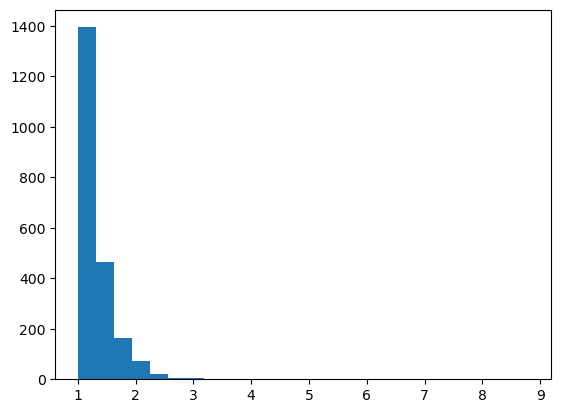

In [1889]:
# taking a look at the salary ratio distribution (outlier over 10 removed)

salaries = google_jobs_df_cleaned_test[(google_jobs_df_cleaned_test['Salary Ratio'] != '*no salary found*') & (google_jobs_df_cleaned_test['Salary Range'] != '*salary ambiguous*')]['Salary Ratio'].to_list()
salaries_filtered = list(filter(lambda x: x < 10, salaries))

plt.hist(salaries_filtered, bins=25)

(array([641., 337., 278., 139., 260., 125., 162.,   0.,  37.,  47.,  49.,
         17.,   8.,  15.,   0.,   5.,   3.,   2.,   2.,   1.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2,
        2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. ]),
 <BarContainer object of 20 artists>)

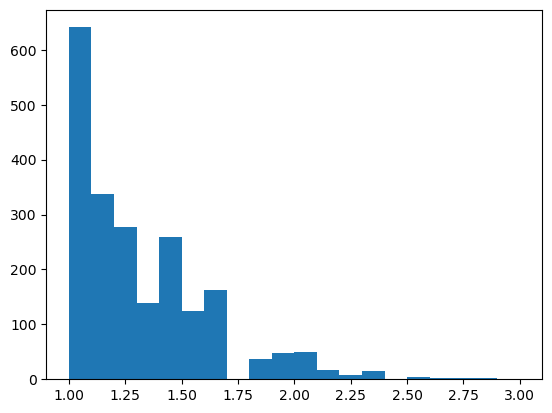

In [1890]:
# taking a closer look at the salary ratio distribution below 3

salaries_filtered = list(filter(lambda x: x <= 3, salaries))

plt.hist(salaries_filtered, bins=20)

In [1891]:
# quartiles for salary ratio

google_jobs_df_cleaned_test[(google_jobs_df_cleaned_test['Salary Ratio'] != '*no salary found*') & (google_jobs_df_cleaned_test['Salary Range'] != '*salary ambiguous*')]['Salary Ratio'].astype(float).describe()


count    2142.000000
mean        2.083333
std        35.987492
min         1.000000
25%         1.000000
50%         1.200000
75%         1.400000
max      1666.700000
Name: Salary Ratio, dtype: float64

In [1892]:
# sample of job postings with salary ratio in top 75%

google_jobs_with_salaries[google_jobs_with_salaries['Salary Ratio'] > 1.4].head(20)

,Role,Company,Location,Posted,Source,All Sources Listed,Full / Part Time,Scraped Salary,Job Highlights,Job Description,Any Other Text,Date Scraped,Salary From Text,Salary Lower Bound,Salary Upper Bound,Salary Range,Salary Ratio,Notes
0,Community Health Worker/Patient Services Coord...,Mount Sinai Health Systems,"New York, NY",20 hours ago,Careers Mount Sinai,NaN,Full-time,*missing data*,Qualifications•Bachelor’s Degree•3 Years Healt...,Description\n\nThe Community Healthcare Worker...,NaN,NaN,"[17.0, 31.6]",17.0,31.6,$17.00-$31.60,1.9,
7,Sr Renewal Account Manager - Alliance & Partne...,ServiceNow,"New York, NY",17 hours ago,Built In NYC,NaN,Full-time,113K–188K a year,Qualifications•7+ years of demonstrated succes...,"Company Description\nAt ServiceNow, our techno...",NaN,NaN,"[$113,400, $187,600]",113000.0,188000.0,"$113,000.00-$188,000.00",1.7,
15,Cost Engineer,MLJ Contracting Corp,"New York, NY",4 hours ago,LinkedIn,NaN,Full-time,85K–150K a year,Qualifications•Candidate subject matter expert...,Final compensation will be based on a combinat...,NaN,NaN,[],85000.0,150000.0,"$85,000.00-$150,000.00",1.8,
21,"Policy Partnerships Lead, TBD (Remote)",Block,Anywhere,17 hours ago,Built In NYC,NaN,Full-time,111K–169K a year,Qualifications•You are familiar with decentral...,"Company Description\nFounded in July 2021, TBD...",NaN,NaN,"[$128,500, $157,100, $121,700, $148,700, $110,...",111000.0,169000.0,"$111,000.00-$169,000.00",1.5,
26,"Director, Operations (Leagues Cup)",Major League Soccer,"New York, NY",12 hours ago,Ladders,NaN,Full-time and Part-time,100K–150K a year,Qualifications•Bachelor’s Degree in Sports Man...,"Overview\n\nThe Director, Leagues Cup Operatio...",NaN,NaN,"[$115,000, $130,000, $500]",100000.0,150000.0,"$100,000.00-$150,000.00",1.5,
68,Associate Dev Ops Engineer,Scholastic,"New York, NY",2 hours ago,SimplyHired,NaN,Full-time,58.5K–93.5K a year,Qualifications•HOW YOU CAN FIT (Qualifications...,Job Description:\n\nTHE OPPORTUNITY...\n\nScho...,NaN,NaN,[],58500.0,93500.0,"$58,500.00-$93,500.00",1.6,
91,Electrical Testing Group Leader - Now Hiring,Bala Consulting Engineers,"New York, NY",14 hours ago,Snagajob,NaN,Full-time and Part-time,16.92–29.47 an hour,Qualifications•Suitable candidates need to pos...,Bala Consulting Engineers is a 200-person engi...,NaN,NaN,[],16.92,29.47,$16.92-$29.47,1.7,
108,988 Contracts Manager,Vibrant Emotional Health,"New York, NY",14 hours ago,Snagajob,NaN,Full-time and Part-time,42.54–82.85 an hour,"Qualifications•Excellent verbal, written, and ...",Position:\n\n988 Contracts Manager...\n\nLocat...,NaN,NaN,[],42.54,82.85,$42.54-$82.85,1.9,
109,Release of information,Nuvance Health,"New York, NY",20 hours ago,Talent.com,NaN,Full-time,*missing data*,Responsibilities•This position is responsible ...,Summary :\n\nThis position is responsible for ...,NaN,NaN,"[$18.3900, $34.1400]",18.39,34.14,$18.39-$34.14,1.9,
110,"VP, Email Campaign Operations",Morgan Stanley,"New York, NY",14 hours ago,ZipRecruiter,NaN,Full-time,100K–180K a year,*missing data*,*missing data*,"VP, Email Campaign Operations SUMMARY We're lo...",NaN,"[$100,000, $180,000]",100000.0,180000.0,"$100,000.00-$180,000.00",1.8,


In [ ]:
# outstanding issues:

# investigate duplicates to make sure all are removed
# index 120: '$50 billion' gets counted as a $50 salary when it's really talking about the industry/ company
    # check if item in list after the number is in a list of words like Bil, M, billion etc
# index 36: $130,000.00 - 150,000.00 will not pull second value
# index ?: ['RATE...\n\n$15', '20/hr\n\nPOSITION'] -> becomes .15 instead of 15 (throwing off ratio)
    # maybe only keep period if a number proceeds and follows it -> #.#

# index 3619: Pay range: (USD)31.12 hrly -(USD)64.80 hrly not being picked up as salary
# index 30: salary in title, not being found
# index 100: when user adds K to the end of an unabbreviated number... maybe not worth trying to fix cause pretty rare error
# index 139: user error entry, adding extra 0 to one entry... not really worth automating this away, maybe just have 
    # to find outliers and manually correct or drop once data is collected
# consider sitation where bonus is listed along with single salary number... would be inaccurate
# there are false positive cases like when just a bonus is included
    # remove numbers that much smaller than the rest/ average?

## ^ for these issues, maybe just look at entries with really weird ratios or "salary ambiguous" tags and manually fix them

# fixed issues:

# index 114: when lower bound is higher than upper bound -> fixed by sorting the list
# lists that are more than 2 items long (for both functions) -> right now, addressed by saying "salary ambiguous"
# index 118: 
    # $80,000-$90,000/ year plus commissions and incentives in the range of $20,000-$30,000/ year
    # Ouput: 8000090000.0 - 2000030000.0
    # right now, addressed by saying "salary ambiguous"
# index 65: [1,800, $118,000—$210,000] leads to 1800.0 and 118000210000.0 
    # weirdly there are two kinds of '—' it seems despite them looking indentical, so just added the extra one in
# index 3 and others: sorts alphabetically, not numerically 
    # sorted(scraped_df['Salary From Description'][3])[0]
# index 120: $50MM+ gets counted as a salary when it's really talking about the industry/ company
    # remove all numbers that contain m or b
# index 1, 11: cases where salary range (or just single salary) is repeated twice labeled as ambiguous
    # remove duplicates from lists (round all of them to avoid decimal issues)
    # this could help if scanning Job Highlights and Descriptions in one go as well
# index ?: if $130,000.00- $150,000.00 or $130,000.00 -$150,000.00 will be deemed ambiguous
    # use method saved below to break numbers up, and if the result is still just two numbers, use them, if not, deem ambiguous

## Old Code

In [ ]:
# # url filters: jobs posted within past day, within 15 miles of New York, NY
# google_jobs_url = 'https://www.google.com/search?q=jobs&oq=google+jobs+data+analyst&aqs=chrome..69i57j69i59j0i512j0i22i30i625l4j69i60.4543j0j7&sourceid=chrome&ie=UTF-8&ibp=htl;jobs&sa=X&ved=2ahUKEwjXsv-_iZP9AhVPRmwGHX5xDEsQutcGKAF6BAgPEAU&sxsrf=AJOqlzWGHNISzgpAUCZBmQA1mWXXt3I7gA:1676311105893#fpstate=tldetail&htivrt=jobs&htichips=city:Owg_06VPwoli_nfhBo8LyA%3D%3D,date_posted:today&htischips=city;Owg_06VPwoli_nfhBo8LyA%3D%3D:New%20York_comma_%20NY,date_posted;today&htilrad=24.1401&htidocid=9dwQD_uVzp1Nu-9BAAAAAA%3D%3D'
# # path to CSV where google jobs dataset will be held
# google_jobs_df_path = '/Users/ravram/Desktop/pay-transparency/data/output/google-jobs-cronjob.csv' # need to change path when put on server
# # path to CSV where extra column data will be held
# extra_columns_df_path = '/Users/ravram/Desktop/pay-transparency/data/output/google-jobs-extra-cols-cronjob.csv' # need to change path when put on server

# def scrape_google_jobs(url, final_path_location, postings):
    
# # url: web url to the google jobs page that will be scraped (str)
# # final_path_location: path to the CSV file where the scraped data will be stored (str)
# # postings: number of job postings to be scraped -> can be increased by increments of 10 starting at 20, going up to limit of 150 (int)
    
#     options = Options() # preparing to run in headless browser
#     options.add_argument('headless') 

#     # using sing selenium to launch and scroll through the Google Jobs page
#     url = url
#     driver = webdriver.Chrome(options=options)
    
#     user_agent = driver.execute_script("return navigator.userAgent;")
#     user_agent = user_agent.replace("HeadlessChrome","Chrome")
#     driver.execute_cdp_cmd('Network.setUserAgentOverride',{"userAgent": f'{user_agent}'})
    
#     driver.get(url)

#     # column names and paths to desired data
#     xpaths = { 
#      'Role'            :"./div/div[1]/div/div[1]/h2",
#      'Company'         :"./div/div[1]/div/div[2]/div[2]/div[1]",
#      'Location'        :"./div/div[1]/div/div[2]/div[2]/div[2]",
#      'Posted'          :"./div/div[3]/div[1]/span[2]/span",
#      'Scraped Salary'  :".//span[@class='LL4CDc' and contains(@aria-label,'Salary')]/span",
#      'Job Highlights'  :"./div/div[4]/div[1]/div[2]/g-expandable-container/div/g-expandable-content[2]/span",
#      'Job Description' :"./div/div[5]/div/span",
#      'Any Other Text'  :"./div/div[4]" 
#     }
    
#     scrolls_to_do = postings # setting number of job postings to be scraped
#     scrolls_done = 0
#     data = {key:[] for key in xpaths} # data will be added to this dict
    
#     # stay in while loop until desired number of postings have been scrolled to
#     while scrolls_done < scrolls_to_do: 
#         lis_scr = driver.find_elements(By.XPATH, "//li[@data-ved]//div[@role='treeitem']/div/div") # path to section of page where user can scroll through job postings 
#         #print('lis length=',len(lis_scr), f'{scrolls_done=}', end='\r')
        
#         if (len(lis_scr) == scrolls_done) and (scrolls_to_do - scrolls_done) > 0: # in case the postings variable exceeds number of available job posting entries (otherwise code will be stuck in infinite loop)
        
#             print('\nNote: requested # of postings greater than available postings')
#             scrolls_to_do = len(lis_scr) # resetting scrolls_to_do to the max length of lis_scr so can break out of while loop
            
#         # scrolling down the page to make desired number of job postings load, therefore making them accessible for scraping
#         for li_scr in lis_scr[scrolls_done:]:
#             driver.execute_script('arguments[0].scrollIntoView({block: "center", behavior: "smooth"});', li_scr) 

#             scrolls_done += 1
#             print(f'{scrolls_done=}', end='\r') # to visualize how many scrolls have been performed
#             time.sleep(.2)     
    
#     lis_descr = driver.find_elements(By.XPATH, "//*[@id='gws-plugins-horizon-jobs__job_details_page']") # path to description page for each job
    
#     print('')
#     jobs_done = 0 
    
#     for li_descr in lis_descr[0:scrolls_to_do]: # looping through desired number of job description pages, which is where the data will be pulled from
    
#         for key in xpaths:

#             try: # pull data at each path in the xpaths dict for each job posting
#                 t = li_descr.find_element(By.XPATH, xpaths[key]).get_attribute('innerText')
#             except NoSuchElementException: # if can't find, indicate with text
#                 t = '*missing data*'
#             if t == '': # in cases where element exists but is just ''
#                 t='*missing data*'
                
#             data[key].append(t) # add to data dict
            
#         jobs_done += 1
#         print(f'{jobs_done=}', end='\r') # to visualize how many jobs have been completed
#         time.sleep(.2)

#     scraped_df = pd.DataFrame(data) # convert to df
    
#     for ind in scraped_df.index: # Any Other Text collects full text for posting... only worth keeping if Job Highlights and Description are empty, otherwise redundant info just taking up space
        
#         if (scraped_df['Job Highlights'][ind] != '*missing data*') and (scraped_df['Job Description'][ind] != '*missing data*'):
            
#             scraped_df.loc[ind, 'Any Other Text'] = np.nan # erasing this text if either Job Highlights or Description is present
    
#     path = final_path_location 
    
#     if os.path.exists(path): # if CSV already exists at the specified path, add the new data found in scraped_df 
#         original_df = pd.read_csv(path) # convert existing CSV to df
#         original_df = pd.concat([original_df,scraped_df]) # add new data
#         original_df = original_df.drop_duplicates(subset=['Role','Company','Location','Scraped Salary','Job Highlights','Job Description', 'Any Other Text']) # drop entries with identical data in these columns... leaving Posted out of this in case duplicates are posted at dif times
#         original_df.to_csv(path, index = False) # redownloading updated df to the specified path
#     else: # otherwise, create new file at this path (for first time function is run)
#         scraped_df.to_csv(path, index = False)
    
#     return 

# scrape_google_jobs(google_jobs_url, google_jobs_df_path, 150)

In [ ]:
# def find_salaries(df, col_name):
    
#     salary_from_col = 'Salary From ' + col_name
    
#     df[salary_from_col] = '' # creating column where salaries found in description will be placed
#     df['Salary Lower Bound'] = '' # lower bound
#     df['Salary Upper Bound'] = '' # upper bound
    
#     for ind in df.index: # iterating through the descriptions for each job

#         salary_list = []

#         phrase = df[col_name][ind] # text in description
#         phrase = phrase.replace('•',' ') # eliminating bullet points
#         phrase_to_list = phrase.split(" ") # creating list of all strings in the description

#         for i in range(len(phrase_to_list)): # iterating through phrase_to_list

#             if len(phrase_to_list[i]) > 0: # otherwise -1 index will break code
                
#                 if phrase_to_list[i] not in ['401K', '401k']: # eliminating '401K' so doesn't get labeled as salary
                    
#                     if not [True if e in phrase_to_list[i].lower() else False for e in ['b','m']][0]: # weeding out cases like '$10b industry' or '$3M company'
                    
#                         if ('$' in phrase_to_list[i]) or ('k' == phrase_to_list[i][-1].lower() and phrase_to_list[i][-2].isdigit()): # looking for salary indicators

#                             salary_list.append(phrase_to_list[i]) # adding strings with salary indicators to ongoing list

#                         if phrase_to_list[i] == '$' and phrase_to_list[i+1][0].isdigit(): # if there's a space between $ and number

#                             salary_list.append(phrase_to_list[i+1]) # add the subsequent list item in this case

#                         df[salary_from_col][ind] = salary_list # place in this new column
          
#         # now that salaries are collected from the description, creating lower and upper bounds based on given info
                
#         if df['Scraped Salary'][ind] == '*missing data*': # if salary not initially scraped
            
#             if df['Salary From ' + col_name][ind] == []: # if no salary found in description
        
#                 df['Salary Lower Bound'][ind] = '*no salary found*'
#                 df['Salary Upper Bound'][ind] = '*no salary found*'
            
#             else: # if salary is found in the description
                
#                 # if first value is just $, remove so doesn't affect making the range (cases where there's originally a space between $ and number)
                
#                 for i in df[salary_from_col][ind]:
#                     if i == '$':
#                         df[salary_from_col][ind].remove('$') 
                        
#                 desc_sal_list = [] # in cases where there are two "numbers" that are really 1-2 ranges -> [20K-30K,5K-6K] or [20K,15K-16K]
                    
#                 for i in range(len(df[salary_from_col][ind])): # removing the dashes and isolating all of the individual numbers

#                     if '–' in df[salary_from_col][ind][i]: 
#                         desc_sal = df[salary_from_col][ind][i].replace('–', ' ')
#                     if '—' in df[salary_from_col][ind][i]: 
#                         desc_sal = df[salary_from_col][ind][i].replace('—', ' ')
#                     elif '-' in df[salary_from_col][ind][i]:
#                         desc_sal = df[salary_from_col][ind][i].replace('-', ' ')
#                     else:
#                         desc_sal = df[salary_from_col][ind][i]

#                     desc_sal_list = desc_sal_list + desc_sal.split(' ')

#                     if '' in desc_sal_list: desc_sal_list.remove('')
                        
#                 df[salary_from_col][ind] = desc_sal_list
                
#                 # attempting to preemptively correct cases that would otherwise trigger 'salary ambiguous' label so that they can be properly processed
                
#                 if len(df[salary_from_col][ind]) > 2: # when length of list > 2, will be marked ambiguous unless corrected first
                    
#                     df[salary_from_col][ind] = clean_salary_ambiguous(df[salary_from_col][ind]) 
                            
#                 # now that all the lists are cleaned, proceed to determine salary ranges:
                
#                 if len(df[salary_from_col][ind]) > 2: # if multiple numbers are still found after cleaning, hard to tell what salary range is, will be marked ambiguous
                    
#                     df['Salary Lower Bound'][ind] = '*salary ambiguous*'
#                     df['Salary Upper Bound'][ind] = '*salary ambiguous*'
                
#                 if len(df[salary_from_col][ind]) == 2: # if two entries provided, create salary range
                    
#                     df['Salary Lower Bound'][ind] = df[salary_from_col][ind][0] 
#                     df['Salary Upper Bound'][ind] = df[salary_from_col][ind][1]
                
#                 elif len(df[salary_from_col][ind]) == 1: # one entry
                                          
#                     df['Salary Lower Bound'][ind] = df[salary_from_col][ind][0] 
                          
#         else: # if salary found in initial scrape, use it as final salary 
            
#             if '–' in df['Scraped Salary'][ind]: # removing dashes
#                 scraped_sal = df['Scraped Salary'][ind].replace('–', ' ')
#             elif '—' in df['Scraped Salary'][ind]: # removing dashes
#                 scraped_sal = df['Scraped Salary'][ind].replace('—', ' ')
#             elif '-' in df['Scraped Salary'][ind]: # removing dashes
#                 scraped_sal = df['Scraped Salary'][ind].replace('-', ' ')
#             else:
#                 scraped_sal = df['Scraped Salary'][ind]
                
#             scraped_sal_list = scraped_sal.split(' ') # seperating into list of strings
            
#             df['Salary Lower Bound'][ind] = scraped_sal_list[0] # first number
#             df['Salary Upper Bound'][ind] = scraped_sal_list[1] # second number

#     return df

In [ ]:
# def scrape_extra_columns(url, final_path_location, postings):
    
# # url: web url to the google jobs page that will be scraped (str)
# # final_path_location: path to the CSV file where the scraped data will be stored (str)
# # postings: number of job postings to be scraped -> can be increased by increments of 10 starting at 20, going up to limit of 150 (int)
    
#     options = Options() # preparing to run in headless browser
#     options.add_argument('headless')

#     # using sing selenium to launch and scroll through the Google Jobs page
#     url = url
#     driver = webdriver.Chrome(options=options)
    
#     user_agent = driver.execute_script("return navigator.userAgent;")
#     user_agent = user_agent.replace("HeadlessChrome","Chrome")
#     driver.execute_cdp_cmd('Network.setUserAgentOverride',{"userAgent": f'{user_agent}'})
    
#     driver.get(url)

#     # column names and paths to desired data
#     xpaths = {
#      'Role'            :"./div[2]",
#      'Company'         :"./div[4]/div/div[1]",
#      'Source'          :"./div[4]/div/div[3]",
#      'Full / Part Time':".//*[name()='path'][contains(@d,'M20 6')]/ancestor::div[1]",
#     }
    
#     jobs_to_do = postings # setting number of job postings to be scraped
#     jobs_done = 0
#     data = {key:[] for key in xpaths} # data will be added to this dict

#     # stay in while loop until desired number of postings have been scrolled to and scraped 
#     while jobs_done < jobs_to_do: 
#         lis = driver.find_elements(By.XPATH, "//li[@data-ved]//div[@role='treeitem']/div/div") # path to section of page where user can scroll through job postings 
#         # print('lis length=',len(lis), f'{jobs_done=}', end='\r')
        
#         if (len(lis) == jobs_done) and (jobs_to_do - jobs_done) > 0: # in case the postings variable exceeds number of available job posting entries (otherwise code will be stuck in infinite loop)
        
#             print('\nNote: requested # of postings greater than available postings')
#             jobs_to_do = len(lis) # resetting scrolls_to_do to the max length of lis_scr so can break out of while loop
        
#         # scrolling down the page to make desired number of job postings load, therefore making them accessible for scraping
#         for li in lis[jobs_done:]:
#             driver.execute_script('arguments[0].scrollIntoView({block: "center", behavior: "smooth"});', li)

#             for key in xpaths:
#                 try: # pull data at each path in the xpaths dict for each job posting
#                     t = li.find_element(By.XPATH, xpaths[key]).get_attribute('innerText')
#                 except NoSuchElementException: # if can't find, indicate with text
#                     t = '*missing data*'
#                 data[key].append(t) # add to data dict

#             jobs_done += 1
#             print(f'{jobs_done=}', end='\r') # to visualize how many jobs have been completed
#             time.sleep(.2)
            
#     cols_to_add = pd.DataFrame(data) # convert to df
        
#     path = final_path_location 
    
#     if os.path.exists(path): # if CSV already exists at the specified path, add the new data found in scraped_df 
#         original_df = pd.read_csv(path) # convert existing CSV to df
#         original_df = pd.concat([original_df,cols_to_add]) # add new data
#         original_df = original_df.drop_duplicates() # drop entries with identical data 
#         original_df.to_csv(path, index = False) # redownloading updated df to the specified path
#     else: # otherwise, create new file at this path (for first time function is run)
#         cols_to_add.to_csv(path, index = False)    
        
#     return 

# scrape_extra_columns(google_jobs_url, extra_columns_df_path, 150) 

In [443]:
# # og method
# #def scrape_google_jobs(google_jobs_df):

# #using selenium to launch and scroll through the Google Jobs page
# url = "https://www.google.com/search?q=in+new+york+city&oq=google+jobs+data+analyst&aqs=chrome..69i57j69i59j0i512j0i22i30i625l4j69i60.4543j0j7&sourceid=chrome&ie=UTF-8&ibp=htl;jobs&sa=X&ved=2ahUKEwjXsv-_iZP9AhVPRmwGHX5xDEsQutcGKAF6BAgPEAU&sxsrf=AJOqlzWGHNISzgpAUCZBmQA1mWXXt3I7gA:1676311105893#fpstate=tldetail&htivrt=jobs&htidocid=DKwJ4ogc_UrLs-QfAAAAAA%3D%3D"
# driver = webdriver.Chrome()
# driver.get(url)

# xpaths = {
#  #'Logo'            :"./div[1]//img",
#  'Role'            :"./div[2]",
#  'Company'         :"./div[4]/div/div[1]",
#  'Location'        :"./div[4]/div/div[2]",
#  'Source'          :"./div[4]/div/div[3]",
#  'Posted'          :".//*[name()='path'][contains(@d,'M11.99')]/ancestor::div[1]",
#  'Full / Part Time':".//*[name()='path'][contains(@d,'M20 6')]/ancestor::div[1]",
#  'Salary'          :".//span[@class='LL4CDc' and contains(@aria-label,'Salary')]/span"
# }

# jobs_to_do = 160
# jobs_done = 0
# data = {key:[] for key in xpaths}

# while jobs_done < jobs_to_do:
#     lis = driver.find_elements(By.XPATH, "//li[@data-ved]//div[@role='treeitem']/div/div")
#     print('lis length=',len(lis), f'{jobs_done=}', end='\r')
    
#     if (len(lis) == jobs_done) and (jobs_to_do - jobs_done) > 0:
        
#         print('\noops')
#         jobs_to_do = len(lis)

#     for li in lis[jobs_done:]:
#         driver.execute_script('arguments[0].scrollIntoView({block: "center", behavior: "smooth"});', li)

#         for key in xpaths:
#             try:
#                 t = li.find_element(By.XPATH, xpaths[key]).get_attribute('src' if key=='Logo' else 'innerText')
#             except NoSuchElementException:
#                 t = '*missing data*'
#             data[key].append(t)

#         jobs_done += 1
#         #print(f'{jobs_done=}', end='\r')
#         time.sleep(.2)

#         scraped_df = pd.DataFrame(data)

# # google_jobs_df = google_jobs_df.append(scraped_df)
# # # google_jobs_df = google_jobs_df.drop_duplicates()

# #     #return google_jobs_df
    
# # scraped_df

In [275]:
# import requests
# from serpapi import GoogleSearch
# import json

# finding location params for NYC

# response = requests.get('https://serpapi.com/locations.json?q=New York&limit=5')
# response_list = response.json()

# response_list

In [ ]:
# from serpapi import GoogleSearch

# serpapi_key = 'd5ff8cd8814fc2d40478abe398700948378acf0cedd38fa0ceb5c8b1a0bb295a'

# params = {
#     'api_key': serpapi_key,                                     # https://serpapi.com/manage-api-key
#     'chips': 'date_posted:week,city:Owg_06VPwoli_nfhBo8LyA==',  # city = NYC, date_posted:week for all data posted in last week
#     'q': 'new york',                                            # search query
#     'hl': 'en',                                                 # language of the search
#     'engine': 'google_jobs',                                    # SerpApi search engine
#     'start': 0                                                  # pagination
# }

# google_jobs_results = []

# while True:
#     search = GoogleSearch(params) # where data extraction happens on the SerpApi backend
#     result_dict = search.get_dict() # JSON -> Python dict

#     if 'error' in result_dict:
#         break
    
#     for result in result_dict['jobs_results']:
#         google_jobs_results.append(result)

#     # increments 'start' parameter to 10 which will trigger Google Jobs to paginate to the next page
#     params['start'] += 10

# #print(json.dumps(google_jobs_results, indent=2, ensure_ascii=False))

In [ ]:
# google_jobs_df = pd.DataFrame(google_jobs_results)
# google_jobs_df

In [ ]:
# print(json.dumps(google_jobs_results, indent=2, ensure_ascii=False))